In [1]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
import numpy as np
from matplotlib import pyplot as plt
import math, os

In [2]:
z_dim = 2
usecuda = False
idgpu = 0
epochs = 40
kwargs = {}

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=200, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=200, shuffle=True, **kwargs)

## Encoder and decoder use the DC-GAN architecture

### Encoder

In [5]:
class ChannelsToLinear(nn.Linear):
    """Flatten a Variable to 2d and apply Linear layer"""
    def forward(self, x):
        b = x.size(0)
        return super().forward(x.view(b,-1))
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        n_filters = 64
        self.conv1 = nn.Conv2d(1, n_filters, 4,2,1)
        self.conv2 = nn.Conv2d(n_filters, n_filters*2, 4, 2,1)
        
        self.toLinear1 =  ChannelsToLinear(n_filters*2*7*7, 1024)
        self.fc1 = nn.Linear(1024,z_dim)
        
        self.lrelu = nn.LeakyReLU(negative_slope=0.1)
        
    def forward(self,x):
        h1 = self.lrelu(self.conv1(x))
        h2 = self.lrelu(self.conv2(h1))
        h3 = self.lrelu(self.toLinear1(h2))
        h4 = self.fc1(h3)
        
        return h4
        
encodermodel = Encoder()
if usecuda:
    encodermodel.cuda(idgpu)       
        
        

### Decoder

In [6]:
class LinearToChannels2d(nn.Linear):
    """Reshape 2d Variable to 4d after Linear layer"""
    def __init__(self, m, n, w=1, h=None, **kw):
        h = h or w
        super().__init__(m, n*w*h, **kw)
        self.w = w
        self.h = h
    def forward(self, x):
        b = x.size(0)
        return super().forward(x).view(b, -1, self.w, self.h)
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        n_filters = 64
        
        self.fc1 = nn.Linear(z_dim,1024)
        self.LineartoChannel = LinearToChannels2d(1024,n_filters*2,7,7)
        self.conv1 = nn.ConvTranspose2d(n_filters*2,n_filters,4,2,1)
        self.conv2 = nn.ConvTranspose2d(n_filters,1,4,2,1)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,z):
        h1 = self.relu(self.fc1(z))
        h2 = self.relu(self.LineartoChannel(h1))
        
        h3 = self.relu(self.conv1(h2))
        h4 = self.sigmoid(self.conv2(h3))
        
        return h4
        
decodermodel = Decoder()
if usecuda:
    decodermodel.cuda(idgpu)    

## MMD Loss Function

In [7]:
def compute_kernel(x, y):
    x_size = x.shape[0]
    y_size = y.shape[0]
    dim = x.shape[1]

    tiled_x = x.view(x_size,1,dim).repeat(1, y_size,1)
    tiled_y = y.view(1,y_size,dim).repeat(x_size, 1,1)

    return torch.exp(-torch.mean((tiled_x - tiled_y)**2,dim=2)/dim*1.0)


def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    return torch.mean(x_kernel) + torch.mean(y_kernel) - 2*torch.mean(xy_kernel)

In [8]:
# Convert a numpy array of shape [batch_size, height, width, 1] into a displayable array 
# of shape [height*sqrt(batch_size, width*sqrt(batch_size))] by tiling the images
def convert_to_display(samples):
    cnt, height, width = int(math.floor(math.sqrt(samples.shape[0]))), samples.shape[1], samples.shape[2]
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height, cnt, cnt, width])
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height*cnt, width*cnt])
    return samples

## Scatter Plot before training the VAE

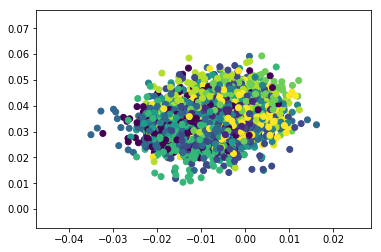

In [9]:
# If latent z is 2-dimensional we visualize it by plotting latent z of different digits in different colors
if z_dim == 2:
    z_list, label_list = [], []
    test_batch_size = 500
    #for i in range(20):
    i = 1
    for batch_idx, (test_x, test_y) in enumerate(test_loader):
        if(i>20):
            break
        test_x= Variable(test_x)
        if(usecuda):
            test_x = test_x.cuda(idgpu)
        z = encodermodel(test_x)   
        z_list.append(z.data.cpu())
        label_list.append(test_y)
        i = i+1
    z = np.concatenate(z_list, axis=0)
    label = np.concatenate(label_list)
    plt.scatter(z[:, 0], z[:, 1], c=label)
    plt.show()

## Training the VAE

/home/pratikm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 0 : Negative log likelihood is 0.071980, mmd loss is 0.121896
Epoch 0 : Negative log likelihood is 0.053884, mmd loss is 0.006514
Epoch 0 : Negative log likelihood is 0.050671, mmd loss is 0.021683


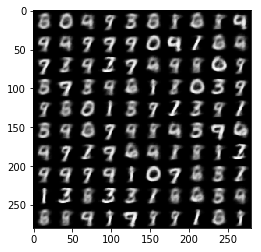

Epoch 1 : Negative log likelihood is 0.048433, mmd loss is 0.013994
Epoch 1 : Negative log likelihood is 0.049103, mmd loss is 0.001879
Epoch 1 : Negative log likelihood is 0.046432, mmd loss is 0.007486


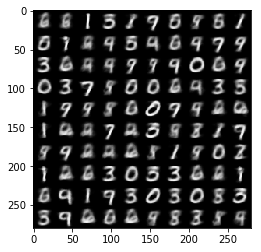

Epoch 2 : Negative log likelihood is 0.045933, mmd loss is 0.004365
Epoch 2 : Negative log likelihood is 0.043363, mmd loss is 0.006224
Epoch 2 : Negative log likelihood is 0.045562, mmd loss is 0.004058


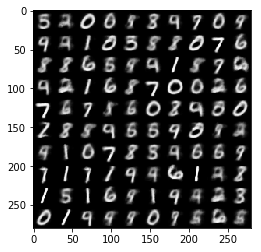

Epoch 3 : Negative log likelihood is 0.046164, mmd loss is 0.003898
Epoch 3 : Negative log likelihood is 0.045396, mmd loss is 0.003387
Epoch 3 : Negative log likelihood is 0.041963, mmd loss is 0.005716


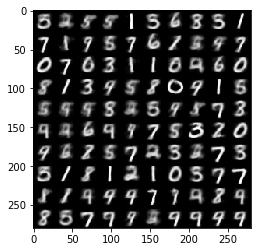

Epoch 4 : Negative log likelihood is 0.042611, mmd loss is 0.018014
Epoch 4 : Negative log likelihood is 0.044999, mmd loss is 0.006595
Epoch 4 : Negative log likelihood is 0.043182, mmd loss is 0.004997


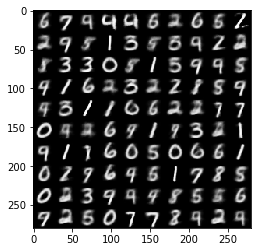

Epoch 5 : Negative log likelihood is 0.041904, mmd loss is 0.013024
Epoch 5 : Negative log likelihood is 0.042593, mmd loss is 0.005823
Epoch 5 : Negative log likelihood is 0.039797, mmd loss is 0.004802


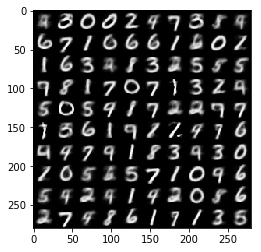

Epoch 6 : Negative log likelihood is 0.041056, mmd loss is 0.002371


KeyboardInterrupt: 

In [11]:
optimizerencoder = optim.Adam(encodermodel.parameters(), lr=1e-3)
optimizerdecoder = optim.Adam(decodermodel.parameters(), lr=1e-3)
for i in range(epochs):

    for batch_idx, (train_x, _) in enumerate(train_loader): 
        train_x= Variable(train_x)
           
        true_samples = torch.randn((len(train_x),z_dim))
        true_samples = Variable(true_samples)
        
        if(usecuda):
            train_x = train_x.cuda(idgpu)
            true_samples = true_samples.cuda(idgpu)
        
        optimizerencoder.zero_grad()
        optimizerdecoder.zero_grad()
        
        train_z = encodermodel(train_x)
        
        train_xr = decodermodel(train_z)
        
        loss_mmd = compute_mmd(true_samples, train_z)
        loss_nll = torch.mean((train_xr - train_x)**2)
        
        loss = loss_nll + loss_mmd
        
        loss.backward()
        
        
        optimizerencoder.step()
        optimizerdecoder.step()
        
        if(batch_idx%100 == 0):
            print("Epoch %d : Negative log likelihood is %f, mmd loss is %f" % (i,loss_nll.data[0], loss_mmd.data[0]))
            
        
    # show images
    gen_z = torch.randn((100, z_dim))
    samples = decodermodel(gen_z)
    samples =samples.view(100,28,28,1)
    plt.imshow(convert_to_display(samples.data), cmap='Greys_r')
    plt.show()   
    

## Scatter Plot after training the VAE

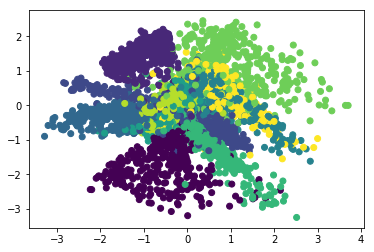

In [12]:
# If latent z is 2-dimensional we visualize it by plotting latent z of different digits in different colors
if z_dim == 2:
    z_list, label_list = [], []
    test_batch_size = 500
    #for i in range(20):
    i = 1
    for batch_idx, (test_x, test_y) in enumerate(test_loader):
        if(i>20):
            break
        test_x= Variable(test_x)
        if(usecuda):
            test_x = test_x.cuda(idgpu)
        z = encodermodel(test_x)   
        z_list.append(z.data.cpu())
        label_list.append(test_y)
        i = i+1
    z = np.concatenate(z_list, axis=0)
    label = np.concatenate(label_list)
    plt.scatter(z[:, 0], z[:, 1], c=label)
    plt.show()